In [35]:
import time
from collections import deque, namedtuple
import gym
import numpy as np
import PIL.Image
import tensorflow as tf
import utils

In [36]:
tf.random.set_seed(utils.SEED)

In [ ]:
MEMORY_SIZE = 100_000     
GAMMA = 0.995             
ALPHA = 1e-3              
NUM_STEPS_FOR_UPDATE = 4

In [38]:
env = gym.make('LunarLander-v2')

In [39]:
env = gym.make('LunarLander-v2', render_mode='rgb_array')
obs, info = env.reset()
frame = env.render()

img = PIL.Image.fromarray(frame)
img.show()

In [40]:
state_size = env.observation_space.shape
num_actions = env.action_space.n

print('State Shape:', state_size)
print('Number of actions:', num_actions)

State Shape: (8,)
Number of actions: 4


In [41]:
# Reset the environment
current_state = env.reset()

In [ ]:
# Reset the environment
current_state, _ = env.reset()
action = 0

# Step through the environment
next_state, reward, terminated, truncated, _ = env.step(action)
done = terminated or truncated

# Display the values
utils.display_table(current_state, action, next_state, reward, done)

# Update the current state
current_state = next_state


/Users/rajnishdadarwal/Documents/Files/Github/moon lander/utils.py:338: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  pd.DataFrame({


In [ ]:
q_network = tf.keras.models.Sequential([
    tf.keras.Input(shape = state_size),
    tf.keras.layers.Dense(units = 64, activation = "relu"),
    tf.keras.layers.Dense(units = 64, activation = "relu"),
    tf.keras.layers.Dense(units = num_actions, activation = "linear")
    ])

target_q_network = tf.keras.models.Sequential([
    tf.keras.Input(shape = state_size),
    tf.keras.layers.Dense(units = 64, activation = "relu"),
    tf.keras.layers.Dense(units = 64, activation = "relu"),
    tf.keras.layers.Dense(units = num_actions, activation = "linear")
    ])

optimizer = tf.keras.optimizers.Adam(learning_rate = ALPHA)

In [44]:
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

In [ ]:
def compute_loss(experiences, gamma, q_network, target_q_network):

  # Unpack the mini-batch of experience tuples
  states, actions, rewards, next_states, done_vals = experiences
    
  # Compute max Q^(s,a)
  max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)
    
  # Set y = R if episode terminates, otherwise set y = R + gamma max Q^(s,a).
  y_targets = rewards + (gamma * max_qsa * (1 - done_vals))
    
  # Get the q_values and reshape to match y_targets
  q_values = q_network(states)
  q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]), tf.cast(actions, tf.int32)], axis=1))
        
  # Compute the loss
  loss = tf.keras.losses.MSE(y_targets, q_values)
  return loss

In [ ]:
@tf.function
def agent_learn(experiences, gamma):
  
  with tf.GradientTape() as tape:
    loss = compute_loss(experiences, gamma, q_network, target_q_network)

  gradients = tape.gradient(loss, q_network.trainable_variables)
  optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

  # update the weights of target q_network
  utils.update_target_network(q_network, target_q_network)

In [ ]:
start = time.time()

num_episodes = 2000
max_num_timesteps = 1000

total_point_history = []

num_p_av = 100    
epsilon = 1.0     

# memory buffer D with capacity N
memory_buffer = deque(maxlen=MEMORY_SIZE)

# target network weights equal to the Q-Network weights
target_q_network.set_weights(q_network.get_weights())

state, _ = env.reset()
total_points = 0

for i in range(max_num_timesteps):
    
    state_qn = np.expand_dims(state, axis=0).astype(np.float32)
    q_values = q_network(state_qn)
    action = utils.get_action(q_values, epsilon)
    
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

    memory_buffer.append(experience(state, action, reward, next_state, done))
    
    if utils.check_update_conditions(i, NUM_STEPS_FOR_UPDATE, memory_buffer):
        experiences = utils.get_experiences(memory_buffer)
        agent_learn(experiences, GAMMA)
    
    state = next_state.copy()
    total_points += reward
    
    if done:
        break

            
    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])
    
    epsilon = utils.get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

    # average of 200 points in the last 100 episodes.
    if av_latest_points >= 200.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('lunar_lander_model.h5')
        break
        
tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episode 69 | Total point average of the last 100 episodes: -63.41
Total Runtime: 1.30 s (0.02 min)


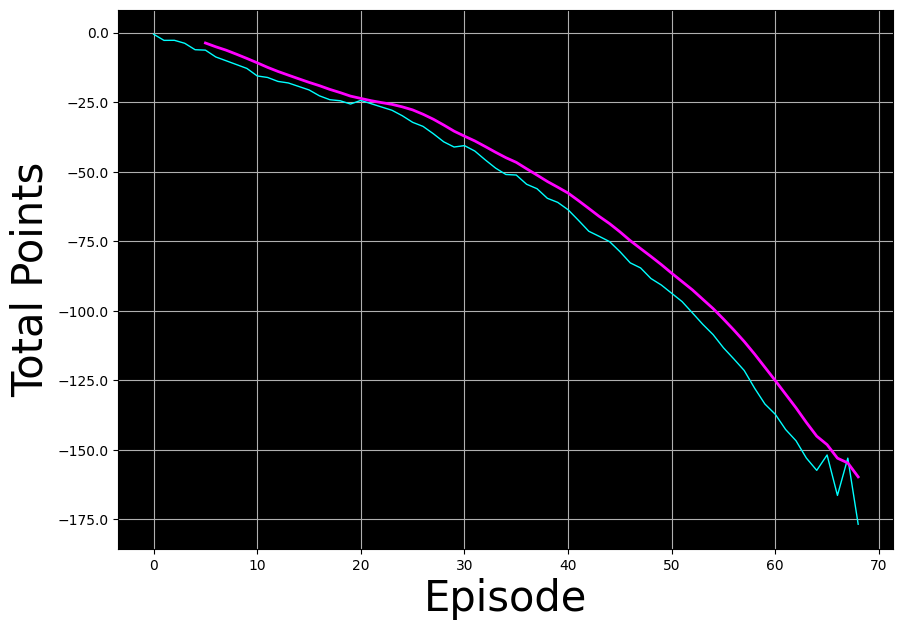

In [ ]:
utils.plot_history(total_point_history)

In [49]:
# Suppress warnings from imageio
import logging
logging.getLogger().setLevel(logging.ERROR)

In [ ]:
# Create the environment with correct render_mode
env = gym.make("LunarLander-v2", render_mode="rgb_array")

# Save video
filename = "video.mp4"
utils.create_video(filename, env, q_network)
utils.embed_mp4(filename)